In [1]:
 seed = 161
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

# Para crear el SVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 

# Metricas
from sklearn.metrics import mean_squared_error as mse


from langdetect import detect



In [2]:
# Se cargan los datos. 
df=pd.read_csv('mbsa.csv',  delimiter=",", header=0)
# Cantidad de datos y número de variables
df.shape

(19344048, 3)

In [3]:
# Mostrar los datos
df.head()

,Date,text,Sentiment
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...,Positive
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...,Positive
2,2019-05-27,Another Test tweet that wasn't caught in the s...,Positive
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,Positive
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,Positive


In [4]:

df.describe()

,Date,text,Sentiment
count,19344048,19344032,18452904
unique,1917,14876178,3
top,2018-08-03,$EPAZ's Bitcoin Sharing &amp; Blockchain Socia...,Negative
freq,995986,891106,9729297


In [5]:
dft = df.sample(50000)
dft

,Date,text,Sentiment
18140197,2019-11-03,@KennethBosak You’re a bitcoin co founder! You...,Negative
2853810,2018-08-01,Mirror skilled traders automatically with Bitc...,Negative
6960471,2019-06-17,Bitcoin mining. Earn up to 30.000 Satoshi per ...,Positive
14074432,2019-09-02,"What is funny is that when I am bearish, Bitco...",Positive
4782956,2017-10-08,New #btce bitcoin 24 hour high of $4718.856,Positive
...,...,...,...
9500110,2019-07-11,Jerome Powell hace caer al bitcoin,Negative
13007288,2019-08-15,@KailiJoy Grow your Bitcoin with the best bitc...,Positive
17776578,2019-10-28,@mattos18k Se não vê eu na quarta feira no btc...,Negative
10308682,2019-07-15,$EPAZ's Bitcoin Sharing &amp; Blockchain Socia...,NaN


In [6]:
dft.shape

(50000, 3)

In [7]:
# Se estandariza la informacion

# funcion para asignar idioma
def getLanguage (row):
    try:
        return detect(row['text'])
    except:
        return ''

# filtrar por idoma
dft['language']=dft.apply (lambda row: getLanguage(row), axis=1)
dft=dft[dft['language']=='en']


dft['Sentiment'].replace({'Positive':1, 'Negative':0}, inplace = True)
dft=dft[dft['Sentiment'].isin([1,0])]

C:\Users\sanva\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [8]:
def is_date(dates):
    result = []
    for date in dates:
        try: 
            datetime.datetime.strptime(date, '%Y-%m-%d')
            result.append(date)
        except ValueError:
            a=''
    return result

validDates = is_date(dft['Date'])

dft=dft[dft['Date'].isin(validDates)]

In [9]:
dft.shape

(33798, 4)

In [10]:
pd.value_counts(dft['Sentiment'])

0    17048
1    16750
Name: Sentiment, dtype: int64

In [11]:
dft.head()

,Date,text,Sentiment,language
18140197,2019-11-03,@KennethBosak You’re a bitcoin co founder! You...,0,en
2853810,2018-08-01,Mirror skilled traders automatically with Bitc...,0,en
6960471,2019-06-17,Bitcoin mining. Earn up to 30.000 Satoshi per ...,1,en
14074432,2019-09-02,"What is funny is that when I am bearish, Bitco...",1,en
4782956,2017-10-08,New #btce bitcoin 24 hour high of $4718.856,1,en


In [12]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def labelWeekDay (row):
    return datetime.datetime.strptime(row['Date'], '%Y-%m-%d').weekday()
     
dft['weekday_label']=dft.apply (lambda row: labelWeekDay(row), axis=1)


In [13]:
# nuevo dataframe para trabajar en el modelo y seleccionar keywords
df_model = dft.copy()
df_model.head()

,Date,text,Sentiment,language,weekday_label
18140197,2019-11-03,@KennethBosak You’re a bitcoin co founder! You...,0,en,6
2853810,2018-08-01,Mirror skilled traders automatically with Bitc...,0,en,2
6960471,2019-06-17,Bitcoin mining. Earn up to 30.000 Satoshi per ...,1,en,0
14074432,2019-09-02,"What is funny is that when I am bearish, Bitco...",1,en,0
4782956,2017-10-08,New #btce bitcoin 24 hour high of $4718.856,1,en,6


In [14]:
def labelKeyWord(row,word):
    return row['text'].count(word)

keyWords=['bitcoin','up','down','buy','sell','use','wait','wallet','btc']

for word in keyWords:
    df_model[word]=df_model.apply (lambda row: labelKeyWord(row, word), axis=1)

In [15]:
df_model = df_model.drop(['text', 'Date', 'language'], axis=1)
df_model.head()

,Sentiment,weekday_label,bitcoin,up,down,buy,sell,use,wait,gained,lost
18140197,0,6,3,0,0,0,0,0,0,0,0
2853810,0,2,0,0,0,0,0,0,0,0,0
6960471,1,0,0,1,0,0,0,0,0,0,0
14074432,1,0,0,0,1,0,0,0,0,0,0
4782956,1,6,1,0,0,0,0,0,0,0,0


In [16]:
df_model.shape

(33798, 11)

In [39]:
df_model = df_model.astype(dtype="float64")
df_model.dtypes

Sentiment        float64
weekday_label    float64
bitcoin          float64
up               float64
down             float64
buy              float64
sell             float64
use              float64
wait             float64
gained           float64
lost             float64
dtype: object

In [47]:
df_model.sum()

Sentiment        16750.0
weekday_label    98678.0
bitcoin          12120.0
up                4215.0
down               624.0
buy               1274.0
sell               934.0
use               1544.0
wait               212.0
gained              15.0
lost                85.0
dtype: float64

# Construcción del modelo

In [40]:
# Se selecciona la variable objetivo, en este caso 'Sentiment'.
Y = df_model['Sentiment']
# Del conjunto de datos se elimina la variable 'Sentiment'.
X = df_model.drop(['Sentiment'], axis=1)


In [41]:
# Dividir los datos en entrenamiento y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [42]:
#Support vector machine con kernel lineal
svc = SVC(kernel = 'linear')
svc = svc.fit(X_train, Y_train)

In [43]:
y_pred = svc.predict(X_test)

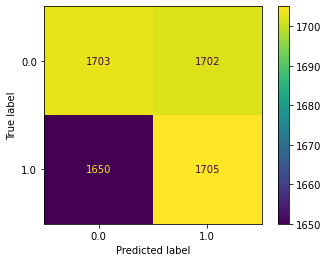

In [44]:
#Matriz de confusion
plot_confusion_matrix(svc, X_test, Y_test)  
plt.show()

In [45]:
#Reporte con las metricas
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.50      0.50      3405
         1.0       0.50      0.51      0.50      3355

    accuracy                           0.50      6760
   macro avg       0.50      0.50      0.50      6760
weighted avg       0.50      0.50      0.50      6760



In [46]:
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test,y_pred)))
print("Precisión: {}".format(precision_score(Y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred)))

Exactitud: 0.50
Recall: 0.5081967213114754
Precisión: 0.5004402700322864
Puntuación F1: 0.5042886719905353
